In [1]:
import os, json, sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from m_lime.explainers.linear import ExplainerLinear

from m_lime.explainers.visualization import ImagePlot
from m_lime.densities.density_vae import DensityVAE

# Loadind data and Model

In [3]:
import torch
import torch.utils.data
from torchvision import datasets, transforms

from playground.models import mnist_CNN

In [4]:
epochs = 10
cuda = torch.cuda.is_available()
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
device = torch.device("cuda" if cuda else "cpu")
device_cpu = torch.device("cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tiagobotari/tiagobotari/data/MNIST1/', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/media/tiagobotari/tiagobotari/data/', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [5]:
path='mode_mnist_cnn.pth'
model = mnist_CNN.model_load(device, path=path)
def model_predict(x_):
    if isinstance(x_, torch.Tensor):
        x_tf = x_
    else:
        x_tf = torch.from_numpy(x_)
    with torch.no_grad():
        x_tf = x_tf.reshape(-1, 1, 28, 28)
        y = model(x_tf.to(device=device))
        y = y.data.exp().to(device_cpu).numpy()
        return y

In [6]:
examples = enumerate(test_loader)
batch_idx, (x_examples, example_targets) = next(examples)

In [7]:
def plot_instances(ax=None, x_=None, y_=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_title(y_)
    return ax.imshow(x_, interpolation = 'none')

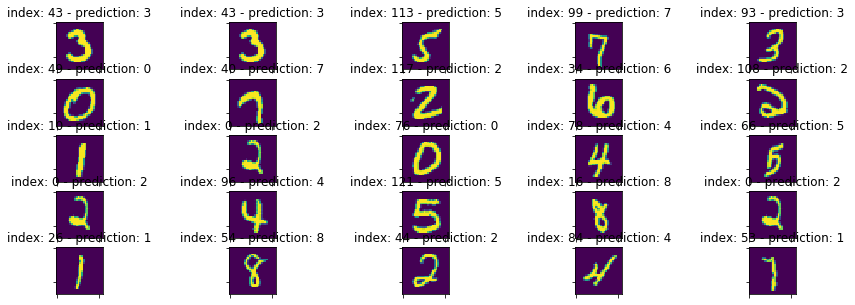

In [8]:
fig, axis = plt.subplots(5,5, figsize=(15, 5))
axis = axis.reshape(-1)
for ax in axis:
     index = np.random.choice(range(125))
     x_explain = x_examples[index][0]
     with torch.no_grad():
         y = model_predict(x_explain.view(-1, 1, 28, 28))
         y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y))
     cp = plot_instances(ax, x_explain, y)

## DensityVAE

In [9]:
density = DensityVAE(input_dim=784)
# density.fit(train_loader, epochs=40)
# density.save_manifold('./mode_vae_manifold_neu.pth')
density = density.load_manifold('./mode_vae_manifold_neu.pth')

### Explain a instance

predicted: 5 0.7852062
top 3 predicted Class [5 3 8]


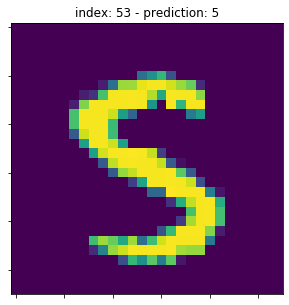

In [10]:
x_explain = np.loadtxt('five_example_s.np').astype(np.float32)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)

print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
fig, axis = plt.subplots(1, figsize=(15, 5))
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
cp = plot_instances(axis, x_explain, y)


## Sampling neighborhood of $x_{explain}$

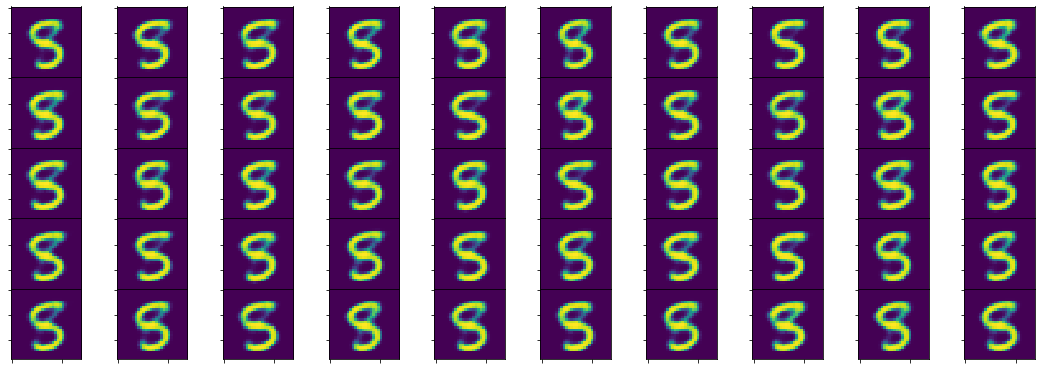

In [11]:
x_sample = density.sample_radius(
    x_exp=x_explain.reshape(-1, 784), r=0.5, n_samples=15000, random_state=None)
fig, axis = plt.subplots(5, 10, figsize=(15, 5))
axis= axis.reshape(-1)
for ax, img_i in zip(axis, x_sample[:50]):
    x_ = img_i.reshape(28, 28)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.imshow(x_, interpolation = 'none')
plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0.01, hspace=0.001)
plt.show()

## Explantion for the top 5 Classes

In [12]:
local_class = 'SGD'
r = 0.8
explain_linear = None
torch.cuda.empty_cache()
class_to_explain = top_three[0]

In [24]:
def explaination(x_explain, model_predict, class_to_explain, local_class, r):
    print('Explanation for ', class_to_explain)
    explain_linear = ExplainerLinear(
        model_predict=model_predict, density=density, local_model=local_class, verbose=False)
    result, contra = explain_linear.explain_instance(
        x_explain=x_explain,
        r=r,
        n_samples=10000,
        class_index=class_to_explain,
        tol=0.05)
    y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
    fig, axis = plt.subplots(1, figsize=(4.5, 4.5))
    ax = plot_instances(axis, x_explain, y)
    a = ImagePlot.plot_importance(result['importance'], standardization=True)
    fig, axis = plt.subplots(1, 2)
    axis = axis.reshape(-1)
    plot = plot_instances(
        axis[1], contra.samples_con[0].reshape(28,28), f'Contrary\n Prob.: {contra.y_con[0]:5.3f}')
    plot = plot_instances(
        axis[0], contra.samples_fav[0].reshape(28,28), f'Favorable\n Prob.: {contra.y_fav[0]:5.3f}')

Explanation for  3


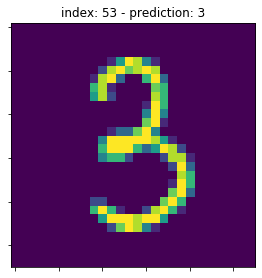

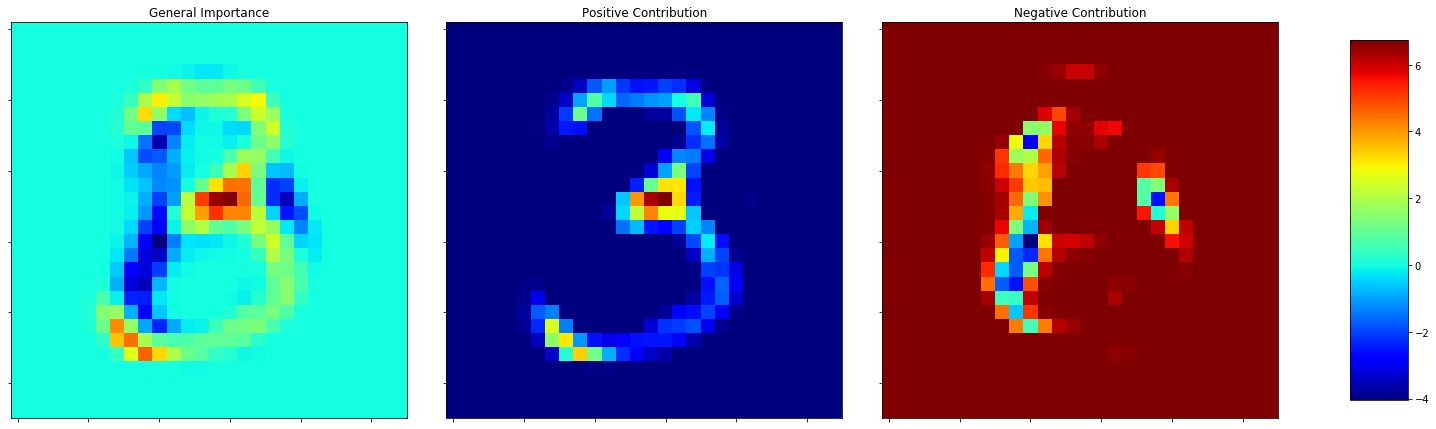

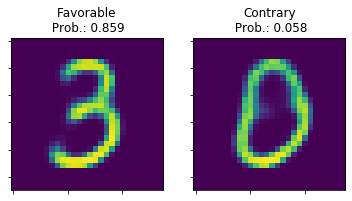

In [25]:
explaination(x_explain, model_predict, top_three[0], local_class, r)

Explanation for  9


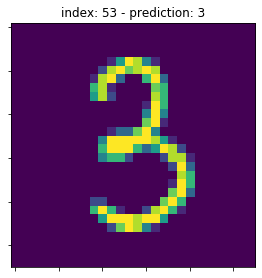

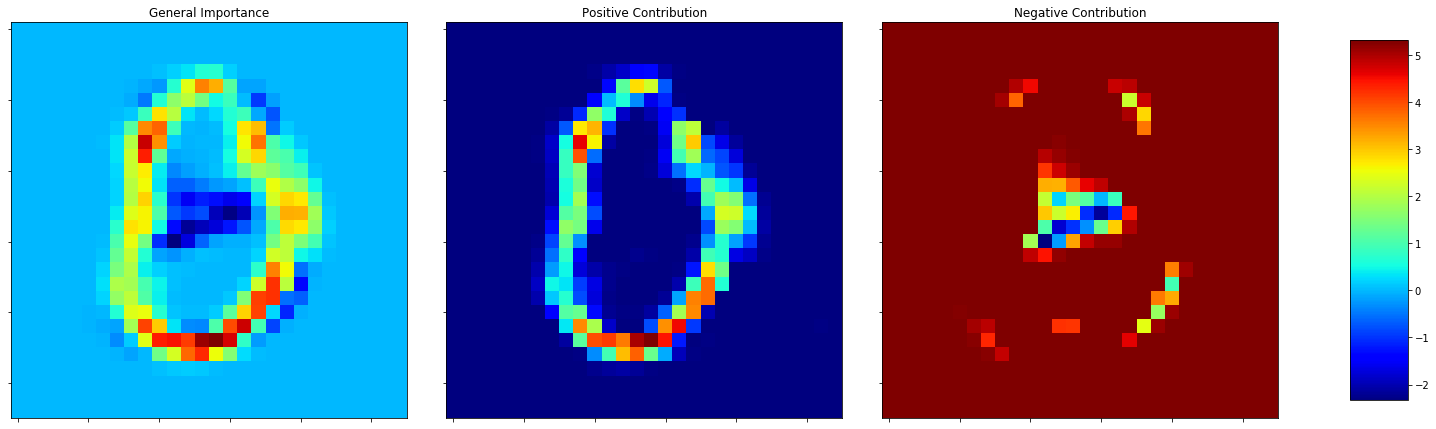

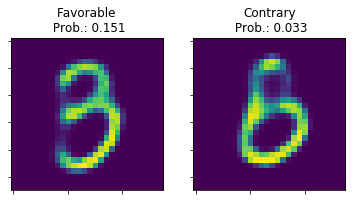

In [26]:
explaination(x_explain, model_predict, top_three[1], local_class, r)

Explanation for  8


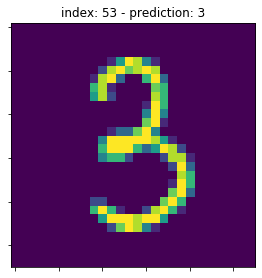

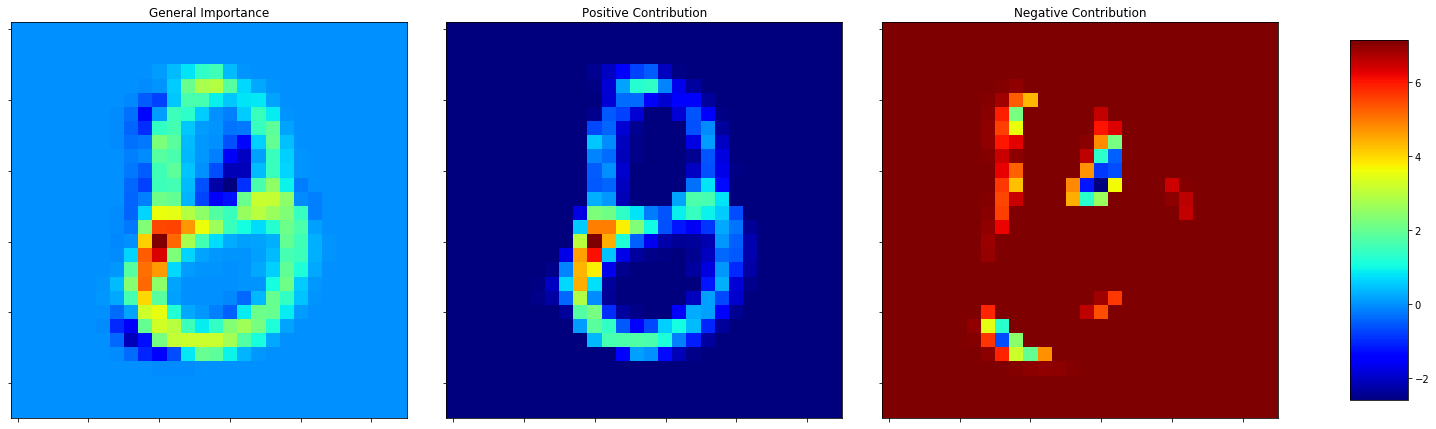

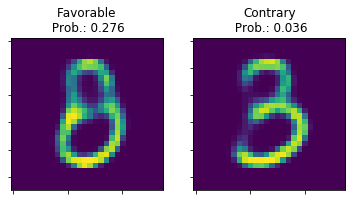

In [27]:
explaination(x_explain, model_predict, top_three[2], local_class, r)

# Explain number 3

predicted: 3 0.8434077
top 3 predicted Class [3 9 8]


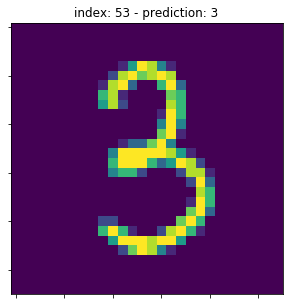

In [28]:
x_explain = np.loadtxt('three_example_.np').astype(np.float32)
y_explain = model_predict(x_explain)
y_explain_index = np.argmax(y_explain)

print('predicted:', y_explain_index, y_explain[0][y_explain_index])
top_three = np.argsort(y_explain)[0][::-1]
print('top 3 predicted Class', top_three[:3])
fig, axis = plt.subplots(1, figsize=(15, 5))
y = 'index: {:} - prediction: {:}'.format(index, np.argmax(y_explain))
cp = plot_instances(axis, x_explain, y)

Explanation for  3


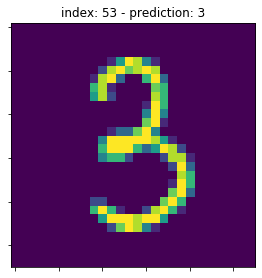

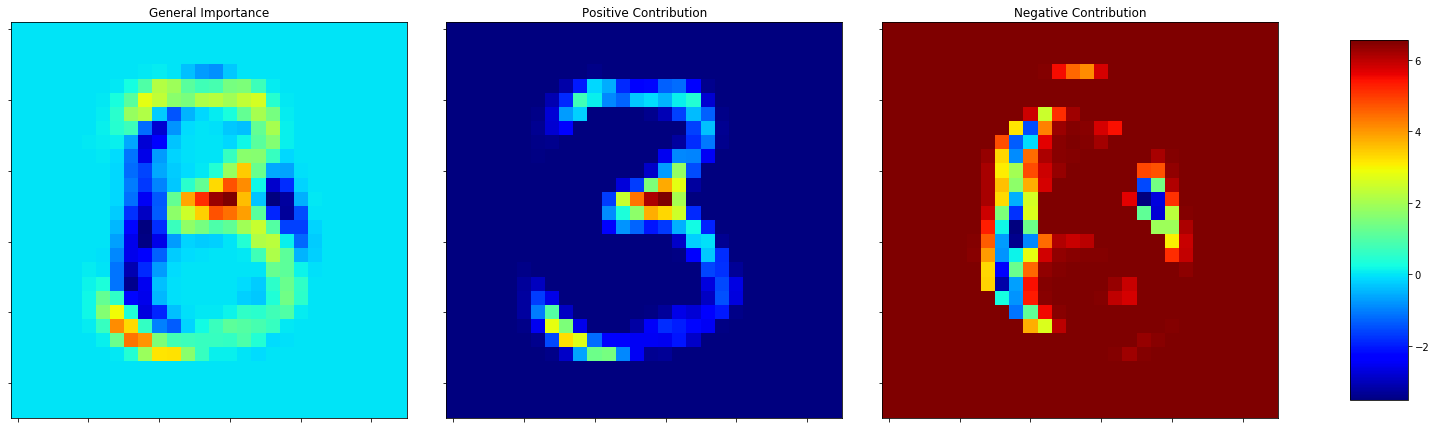

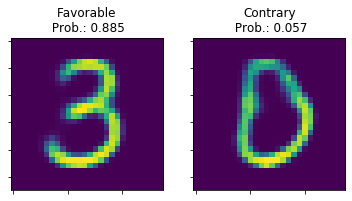

In [29]:
explaination(x_explain, model_predict, top_three[0], local_class, r)

Explanation for  9


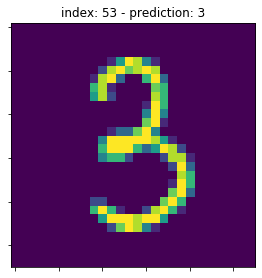

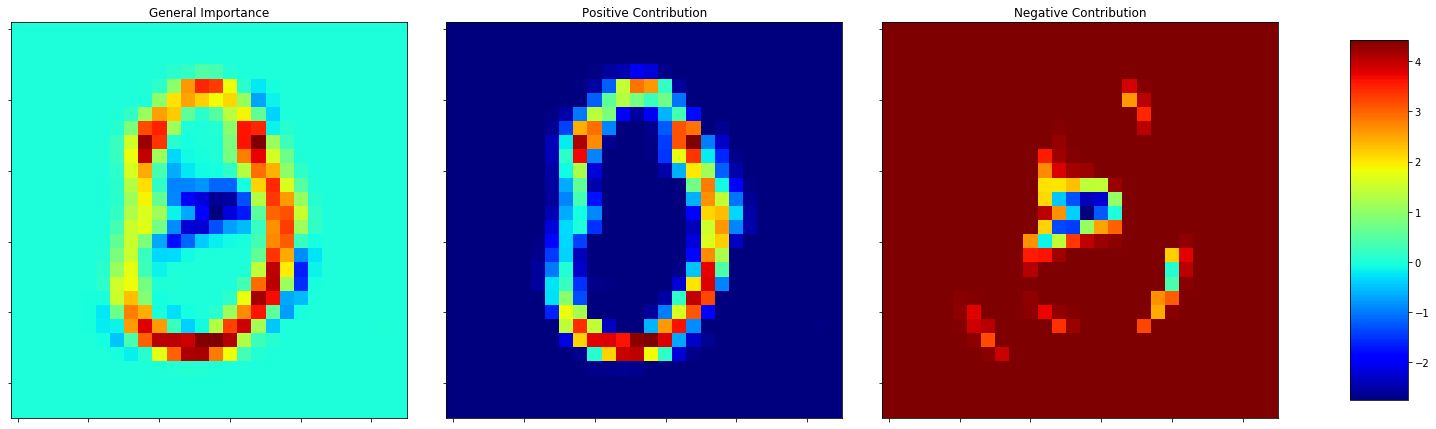

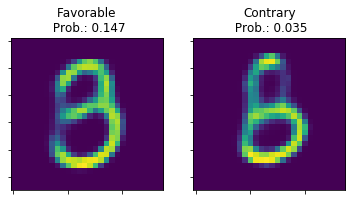

In [30]:
explaination(x_explain, model_predict, top_three[1], local_class, r)

Explanation for  8


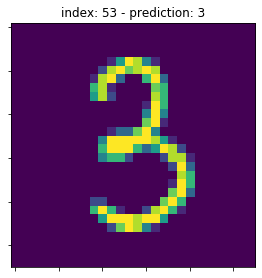

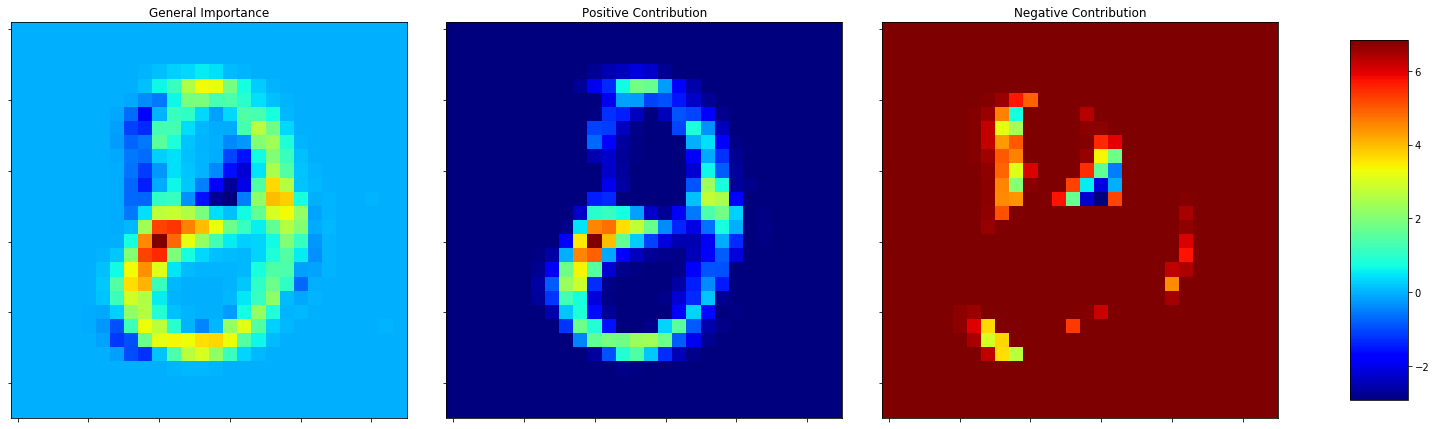

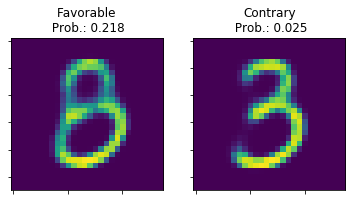

In [31]:
explaination(x_explain, model_predict, top_three[2], local_class, r)

In [32]:
for i in range(100):x
    batch_idx, (x_examples, example_targets) = next(examples)
    print('batch', i)
    
    for index in range(len(example_data)):
        x_explain = x_examples[index][0]
        y = model_predict(x_explain.view(-1, 1, 28, 28))
        ind = np.argmax(y)
        print(ind)
        if ind != 3:
            continue
        fig, ax = plt.subplots( figsize=(15, 5))
        y1 = 'index: {:} - prediction: {:}'.format(index, np.argmax(y))
        cp = plot_instances(ax, x_explain, y1)
        plt.show()
        np.savetxt('five_example.np', x_explain)
        input()

IndentationError: unexpected indent (<ipython-input-32-08eb1d77d648>, line 2)